In [ ]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(train_img_tmp, train_lab_tmp), (test_img_tmp, test_lab_tmp) = mnist.load_data()#only to load data
import matplotlib.pyplot as plt
from tqdm import notebook
import copy

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
#all the activation function and the derivative function will be use in this program
def tanh(x):
  return np.tanh(x)
def softmax(x):
  exp = np.exp(x-x.max())
  return exp/exp.sum()
def d_tanh(data):
  return 1/(np.cosh(data))**2
def d_softmax(data):
  sm = softmax(data)
  return np.diag(sm)-np.outer(sm,sm)

differential = {softmax:d_softmax,tanh:d_tanh}


In [ ]:
dimensions = [28*28,10]# the mnist picture is 28*28,the result is 10 numbers,(from 0 to 9)
activation= [tanh,softmax]
distribution = [
  {'b':[0,0]},
  {'b':[0,0],'w':[-math.sqrt(6/(dimensions[0]+dimensions[1])),math.sqrt(6/(dimensions[0]+dimensions[1]))]}            
]

b0,b1,w1 \
Are the constant and the weight of each layer\
The activation function of each layers are  tanh(x) and softMax

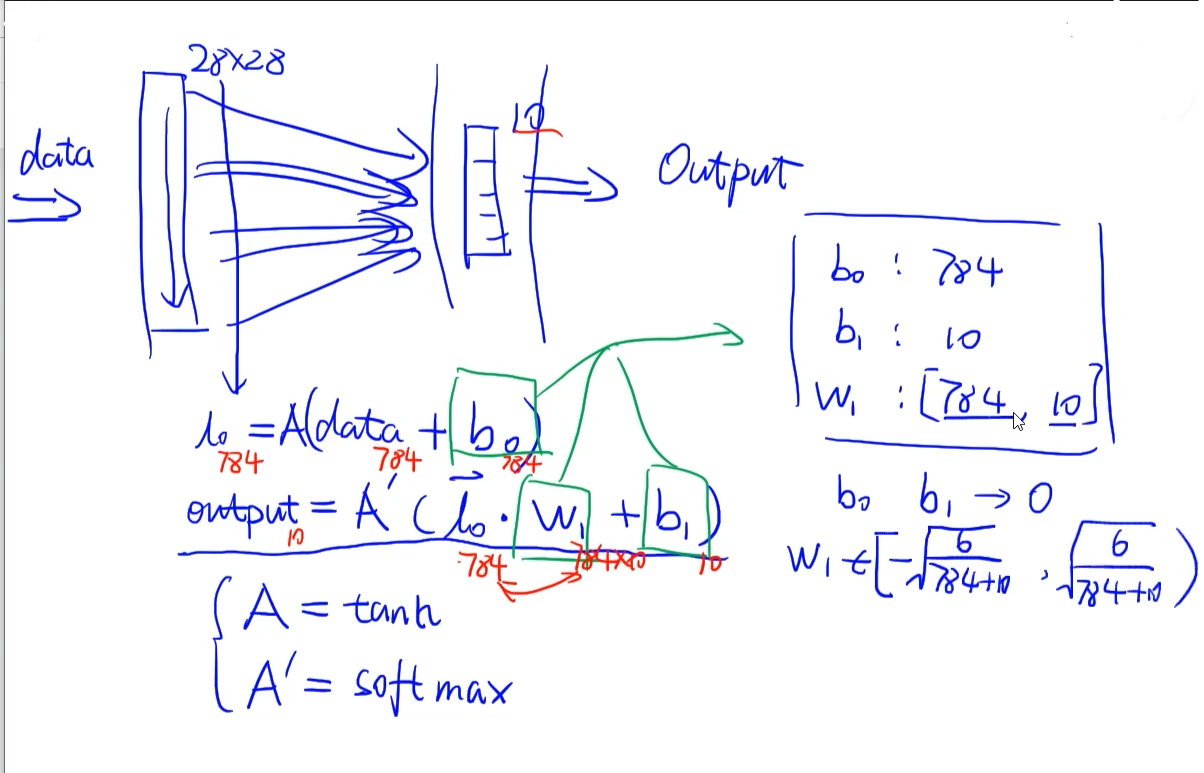

In [ ]:
#initialize the parameter W and B
def init_parameters_b(layer):
  dist = distribution[layer]['b']
  return np.random.rand(dimensions[layer])*(dist[1]-dist[0])+dist[0]
def init_parameters_w(layer):
  dist = distribution[layer]['w']
  return np.random.rand(dimensions[layer-1],dimensions[layer])*(dist[1]-dist[0])+dist[0]
#initialize all the parameters
def init_parameters():
  parameter = []
  for i in range(len(distribution)):
    layer_parameter = {}
    for j in distribution[i].keys():
      if j == 'b':
        layer_parameter['b'] = init_parameters_b(i)
        continue
      if j == 'w':
        layer_parameter['w'] = init_parameters_w(i)  
        continue

    parameter.append(layer_parameter)
  return parameter



In [ ]:
parameters = init_parameters()
# parameters[0]['b']
# init_parameters_w(1)

In [ ]:
def predict(img,parameters):
  l0_in = img+parameters[0]['b']
  l0_out = activation[0](l0_in)
  l1_in = np.dot(l0_out,parameters[1]['w'])+parameters[1]['b']
  l1_out = activation[1](l1_in)
  return l1_out

In [ ]:
#initialize the pictures, split into train group,valid group ,regularize the data into (0~1)
train_num = 50000
vaild_num = 10000
test_num = 10000
train_img = train_img_tmp[:train_num].reshape(-1,28*28)/255
valid_img = train_img_tmp[train_num:].reshape(-1,28*28)/255
train_lab = train_lab_tmp[:train_num]
valid_lab = train_lab_tmp[train_num:]
#Show the picture by ID
def show_train(index):
    
  print('Trainlabel:{},index:{}'.format(train_lab[index],index))
def show_valid(index):
  plt.imshow(valid_img[index].reshape(28,28),cmap='gray')
  print('Test_label:{},index:{}'.format(valid_lab[index],index))

def show_test(index):
  plt.imshow(test_img[index].reshape(28,28),cmap='gray')
  print('Test_label:{},index:{}'.format(test_lab[index],index))



In [ ]:
#predic the picture with untrained parameters,show the picture and the label
pred_res = predict(train_img[0],parameters).argmax()
print(train_lab[0],pred_res)
show_train(0)


5 2
Trainlabel:5,index:0


In [ ]:
show_train(np.random.randint(train_num))#show a random train picture


Trainlabel:2,index:40592


In [ ]:
#test these matrix calculation and derivative
# np.outer([1,2,3,4],[5,6,7,8])
# d_softmax(np.array([1,2,3,4]))
# d_tanh([0.1,0.5,1.5,3.14])

In [ ]:
h = 0.0000001
func = tanh
input_len = 4
for i in range(input_len):
  test_input = np.random.rand(input_len)
  derivative = differential[func](test_input)
  value1 = func(test_input)
  test_input[i]+=h
  value2 = func(test_input)
  # print((value2-value1)/h)
  # print(derivative[i])
  print(derivative[i]-((value2-value1)/h))

[2.61420080e-08 9.17195907e-01 9.17195907e-01 9.17195907e-01]
[7.51202344e-01 3.76699896e-08 7.51202344e-01 7.51202344e-01]
[9.49164110e-01 9.49164110e-01 2.14962516e-08 9.49164110e-01]
[4.33956782e-01 4.33956782e-01 4.33956782e-01 3.37651277e-08]


In [ ]:
onehot = np.identity(dimensions[-1])
onehot[5]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
#loss function,to calculate the loss between predict and label
def sqr_loss(img,lab,parameters):
  y_pred = predict(img,parameters)
  y = onehot[lab]
  diff = y- y_pred
  return np.dot(diff,diff)

In [ ]:
sqr_loss(train_img[0],train_lab[0],parameters)

0.9481402038837934

In [ ]:
# 梯度解析:
# 正向传递FP
# L0=tanh(x+b0)
# L1=L0*w1+b1
# output=softmax(L1)=softmax(L0*w1+b1)=softmax(tanh(x+b0)*w1+b1)
# 损失函数Loss=(y-output)**2
# 反向传播BP
# 调整b0、w1、b1对损失函数的影响?
# 1:对output的偏导-2*(y-output)
# 2:output对L1的偏导(-2*(y-output))*d_softmax(L1)
# 3:L1对w1的偏导(-2*(y-output))*d_softmax(L1)*L0
# 4:L1对b1的偏导(-2*(y-output))*d_softmax(L1)
# 5:L1对L0的偏导w1
# 6:L0对b0的偏导d_tanh(L0)
# 7:BP=(-2*(y-output))*d_softmax(L1)*w1*d_tanh(L0)
# 计算梯度
def grad_parameters(img,lab,parameters):
  # FP正向传递
  l0_in = img+parameters[0]['b']
  l0_out = activation[0](l0_in)
  l1_in = np.dot(l0_out,parameters[1]['w'])+parameters[1]['b']
  l1_out = activation[1](l1_in)
  #BP反向传播
  #误差(y-output)
  diff = onehot[lab] - l1_out
  #act1=(y-output)*d_softmax(L1)
  act1 =  np.dot(differential[activation[1]](l1_in),diff)

  grad_b1 = -2*act1          #4
  grad_w1 = -2*np.outer(l0_out,act1) #3
  grad_b0 = -2*differential[activation[0]](l0_in)*np.dot(parameters[1]['w'],act1)#7
  
  return {'w1':grad_w1,'b1':grad_b1,'b0':grad_b0}

In [ ]:
grad_parameters(train_img[2],train_lab[2],init_parameters())['b0'].shape

(784,)

In [ ]:
#b1
h = 0.001 # step length
for i in range(10):
  img_i = np.random.randint(train_num)
  test_parameters = init_parameters()
  derivative = grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)['b1']
  value1 = sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
  test_parameters[1]['b'][i]+=h
  value2 = sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
  # print(((value2-value1)/h))
  print(derivative)

[ 0.00903848  0.03368146  0.04293724  0.00219545  0.00288636  0.01914487
  0.04686211 -0.17264183  0.01083737  0.00505851]
[ 0.00884913  0.01680374  0.0106599   0.01180404  0.0271073  -0.22675552
  0.10765611  0.01324965  0.00976799  0.02085765]
[ 0.01242365  0.01120856  0.00287712  0.02312778  0.01273005  0.0066927
  0.03190754  0.0301008   0.01787455 -0.14894276]
[ 0.02092987  0.000478    0.01796882  0.00920593  0.0078925   0.03715013
  0.02098947 -0.12593687  0.00613125  0.00519089]
[ 0.00366087  0.01419328  0.01543203  0.00531753  0.02149163  0.02982651
 -0.16789211  0.00291663  0.00441277  0.07064086]
[-0.17332773  0.00385198  0.00488202  0.07219899 -0.00058694  0.00689343
  0.01130324  0.00787148  0.05126398  0.01564956]
[ 0.01071901  0.02069384  0.01451998 -0.16947641  0.03716315  0.00882803
  0.02260048  0.00952532  0.01114828  0.03427831]
[ 0.0479191   0.01799811 -0.28343892  0.01697635  0.02194587  0.02946897
  0.04612591  0.04817657  0.03199278  0.02283526]
[ 0.01975997 -0.1

In [ ]:
#w1
gred_list = []
h = 0.001
for i in range(dimensions[0]):
  for j in range(dimensions[1]):
    img_i = np.random.randint(train_num)
    test_parameters = init_parameters()
    derivative = grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)['w1']
    value1 = sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    test_parameters[1]['w'][i][j]+=h
    value2 = sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    gred_list.append(derivative[i]-((value2-value1)/h))
np.abs(gred_list).max()

0.3433941615605268

In [ ]:
#b0
gred_list = []
h = 0.001
for i in range(dimensions[0]):
  img_i = np.random.randint(train_num)
  test_parameters = init_parameters()
  derivative = grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)['b0']
  value1 = sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
  test_parameters[0]['b'][i]+=h
  value2 = sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
  gred_list.append(derivative[i]-((value2-value1)/h))
np.abs(gred_list).max()

7.924658791673422e-06

In [ ]:
# get the loss and accuracy of valid/trian group when using the current parameters
def valid_loss(parameters):
  loss_accu = 0
  for img_i in range(vaild_num):
    loss_accu += sqr_loss(valid_img[img_i],valid_lab[img_i],parameters)
  return loss_accu/(vaild_num/10000)
def valid_accuracy(parameters):
  correct = [predict(valid_img[img_i],parameters).argmax()==valid_lab[img_i] for img_i in range(vaild_num)]
  return correct.count(True)/len(correct)

def train_loss(parameters):
  loss_accu = 0
  for img_i in range(train_num):
    loss_accu += sqr_loss(train_img[img_i],train_lab[img_i],parameters)
  return loss_accu/(train_num/10000)
def train_accuracy(parameters):
  correct = [predict(train_img[img_i],parameters).argmax()==train_lab[img_i] for img_i in range(train_num)]
  return correct.count(True)/len(correct)

In [ ]:
valid_loss(parameters)#initial model loss before train

8992.354932868671

In [ ]:
valid_accuracy(parameters)#initial model accuracy before train

0.1366

In [ ]:
# train the model by batch
batch_size = 100
def train_batch (current_batch,parameters):
  grad_accumulate = grad_parameters(train_img[current_batch*batch_size+0],train_lab[current_batch*batch_size+0],parameters) 
  for img_i in range(1,batch_size):# train all the pictures in this batch
     grad_temp = grad_parameters(train_img[current_batch*batch_size+img_i],train_lab[current_batch*batch_size+img_i],parameters) # get the current img gradient 
     for key in grad_accumulate.keys():
       grad_accumulate[key]+=grad_temp[key]# add the gradient 
  for key in grad_accumulate.keys():
    grad_accumulate[key]/=batch_size# get the average gradient of this batch
  return grad_accumulate

In [ ]:
train_batch(0,parameters)

{'b0': array([ 7.27622021e-04,  6.36375835e-04,  2.07132859e-03, -1.60178711e-03,
        -4.58210384e-04,  2.45205978e-04, -9.86277415e-04, -2.39237974e-04,
         5.11145175e-04,  2.73059453e-04, -3.73595028e-05, -1.05996758e-03,
         4.38744378e-04,  2.10181760e-03,  2.32405269e-04,  1.05628358e-03,
        -7.75653230e-05,  1.37995526e-03,  1.02507873e-03, -1.26244346e-03,
         3.80640947e-04,  4.90900650e-04, -8.86052991e-05, -3.10263491e-04,
         5.02244661e-04,  4.35502185e-06, -1.74425321e-04, -1.23344898e-03,
         1.10329131e-03,  7.78934961e-05, -1.01009695e-03,  1.30563099e-04,
        -6.40508241e-04, -1.19614659e-03,  1.09354815e-03,  8.11080646e-04,
        -9.63721821e-04,  8.65398492e-04,  1.24398456e-03, -1.77422638e-04,
         1.74263006e-03, -1.45430455e-03,  7.86421943e-05,  1.13175632e-03,
         7.68063974e-05,  1.03925615e-03, -6.02342727e-04, -3.59317367e-05,
         7.96381074e-04,  1.64980814e-03,  3.54220568e-04, -1.45152525e-03,
      

In [ ]:

# DeepCopy the current model and learn by gradient ,step length is the learn_rate
def combine_parameters(parameters,grad,learn_rate):
  parameter_tmp = copy.deepcopy(parameters)
  parameter_tmp[0]['b']-= learn_rate*grad['b0']
  parameter_tmp[1]['b']-= learn_rate*grad['b1']
  parameter_tmp[1]['w']-= learn_rate*grad['w1']
  return parameter_tmp

In [ ]:
combine_parameters(parameters,train_batch(0,parameters),1) # train the first batch ,and combine the gradient with the parameters,by 1 step length

[{'b': array([-7.27622021e-04, -6.36375835e-04, -2.07132859e-03,  1.60178711e-03,
          4.58210384e-04, -2.45205978e-04,  9.86277415e-04,  2.39237974e-04,
         -5.11145175e-04, -2.73059453e-04,  3.73595028e-05,  1.05996758e-03,
         -4.38744378e-04, -2.10181760e-03, -2.32405269e-04, -1.05628358e-03,
          7.75653230e-05, -1.37995526e-03, -1.02507873e-03,  1.26244346e-03,
         -3.80640947e-04, -4.90900650e-04,  8.86052991e-05,  3.10263491e-04,
         -5.02244661e-04, -4.35502185e-06,  1.74425321e-04,  1.23344898e-03,
         -1.10329131e-03, -7.78934961e-05,  1.01009695e-03, -1.30563099e-04,
          6.40508241e-04,  1.19614659e-03, -1.09354815e-03, -8.11080646e-04,
          9.63721821e-04, -8.65398492e-04, -1.24398456e-03,  1.77422638e-04,
         -1.74263006e-03,  1.45430455e-03, -7.86421943e-05, -1.13175632e-03,
         -7.68063974e-05, -1.03925615e-03,  6.02342727e-04,  3.59317367e-05,
         -7.96381074e-04, -1.64980814e-03, -3.54220568e-04,  1.45152525

In [ ]:
parameters = init_parameters()
current_epoch = 0
train_loss_list = []
valid_loss_list = []
train_accu_list = []
valid_accu_list = []  


In [ ]:
print('valid_accuracy,train_accuracy,valid_loss,train_loss before training the model')
valid_accuracy(parameters),train_accuracy(parameters),valid_loss(parameters),train_loss(parameters)

valid_accuracy,train_accuracy,valid_loss,train_loss before training the model


(0.1218, 0.12218, 9082.987650517678, 9077.396307214827)

In [ ]:
#choose a step length and run 1 epoch of batch training,record the loss and the accuracy
learn_rate = 10**0
epoch_num = 5
for epoch in notebook.tqdm(range(epoch_num)):
  for i in range(train_num//batch_size):
    # if i%100==99:
      # print('runnung batch {}/{}'.format(i+1,train_num//batch_size))
    grad_tmp = train_batch(i,parameters)
    parameters = combine_parameters(parameters,grad_tmp,learn_rate)
  current_epoch += 1
  train_loss_list.append(train_loss(parameters))
  valid_loss_list.append(valid_loss(parameters))
  train_accu_list.append(train_accuracy(parameters))
  valid_accu_list.append(valid_accuracy(parameters))

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
valid_accuracy(parameters)# just after one batch training,we got the accuracy of 91.7%

0.9281

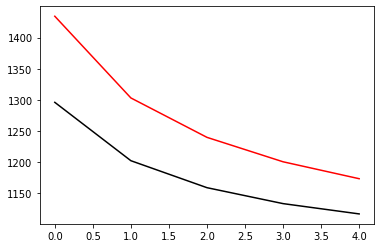

In [ ]:
lower = 0
plt.plot(valid_loss_list[lower:],color = 'black',label = 'validation loss')
plt.plot(train_loss_list[lower:],color = 'red',label = 'train loss')
plt.show()
# after more training,we can have the loss of every training epoch

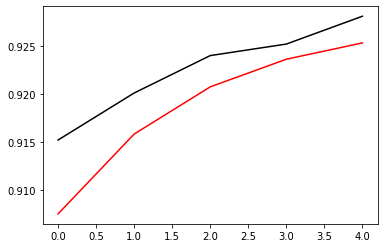

In [ ]:
plt.plot(valid_accu_list[lower:],color = 'black',label = 'validation accuracy')
plt.plot(train_accu_list[lower:],color = 'red',label = 'train accuracy')
plt.show()
# training accuracy result of every epoch

In [ ]:
#we can use random batch to test different learning rate(step length ),and to get the best learning rate to fit our model
rand_batch = np.random.randint(train_num//batch_size)
grad_lr = train_batch(rand_batch,parameters)

In [ ]:

lr_list = []
lower = -3
upper = 2
step = 0.2
for lr_pow in notebook.tqdm(np.linspace(lower,upper,num = np.int((upper//step-lower//step)+1))):
  learn_rate = 10**lr_pow
  parameters_tmp = combine_parameters(parameters,grad_lr,learn_rate)
  train_loss_tmp = train_loss(parameters_tmp)
  lr_list.append([lr_pow,train_loss_tmp])

  0%|          | 0/25 [00:00<?, ?it/s]

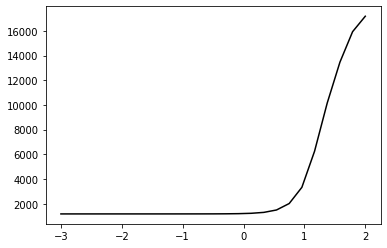

In [ ]:
upper = len(lr_list)
plt.plot(np.array(lr_list)[:upper,0],np.array(lr_list)[:upper,1],color = 'black',label = 'validation accuracy')
plt.show()

### after one epoch of training,We increased the accuracy form 0.1 to 0.9,we will choose next learn rate to have a better model,by repeat the batch training step using the lowest loss 

